# Import Libraries

In [1]:
import os # Tương tác với hệ điều hành, quản lý file và thư mục.
import pandas as pd # Làm việc với dữ liệu dạng bảng(như Excel) dùng đọc file CSV.
import numpy as np
from sklearn.model_selection import train_test_split # Chia dữ liệu thành 2 tập: training và testing.
from sklearn.preprocessing import MinMaxScaler, LabelEncoder # Dùng để chuẩn hóa dữ liệu (đưa giá trị của các cột về cùng một thang đo từ 0 đến 1).
# Mã hóa nhãn (chuyển các nhãn dạng chữ thành các số).
from imblearn.over_sampling import SMOTE # Xử lý mất cân bằng dữ liệu.
from tensorflow.keras.models import Sequential # Tạo mô hình tuần tự, nơi các lớp được xếp chồng lên nhau.
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input 
# Input: khai báo định dạng đầu vào cho mô hình.
# LSTM: Long Short-Term Memory
# Dense: Lớp kết nối đầy đủ (fully connected), là lớp nơ-ron cơ bản nhất.
# Dropout: Một kỹ thuật giúp chống Overfitting (mô hình học thuộc dữ liệu training).
from keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping: Dừng quá trình huấn luyện sớm nếu hiệu năng trên tập validation không còn cải thiện, giúp tiết kiệm thời gian và tránh Overfitting.
# ModelChechpoint: Lưu phiên bản tốt nhất của mô hình trong suốt quá trình huấn luyện.
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import to_categorical # Chuyển đổi nhãn dạng số thành dạng one-hot encoding.

# Load Data

In [ ]:
# Đọc các file có đuôi .csv trong đường dẫn.
dataset_path = "../data/raw/CSE-CIC-IDS2018"
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.csv')]

# Tạo một danh sách rỗng để chứa các dataframe đã xử lý.
processed_frames = []
# SAMPLE_SIZE = 50000 # Lấy 50.000 dòng từ mỗi file.

print(f"Start processing {len(all_files)} file...")

# Xử lý từng file 1
for file in all_files:
    try:
        # Đọc một file vào bộ nhớ.
        df = pd.read_csv(file)
        processed_frames.append(df)
        # # Kiểm tra số dòng của file và lấy mẫu
        # if len(df) > SAMPLE_SIZE:
        #     processed_frames.append(df.sample(n=SAMPLE_SIZE, random_state=42))
        # else:
        #     processed_frames.append(df)

        print(f"Completed processing: {os.path.basename(file)}")
    except Exception as e:
        print(f"Error read file {file}: {e}")

# Ghép nối tất cả các dataframe trong danh sách lại.
print("Concatenating dataframes...")
if processed_frames:
    combined_df = pd.concat(processed_frames, ignore_index=True)
    print("Completed!")

    combined_df.info()
    print(combined_df.head())
else:
    print("No files are processed!")

Start processing 14 file...
Completed processing: Bot.csv
Completed processing: Brute Force -Web.csv
Completed processing: Brute Force -XSS.csv
Completed processing: DDOS attack-HOIC.csv
Completed processing: DDOS attack-LOIC-UDP.csv
Completed processing: DDoS attacks-LOIC-HTTP.csv
Completed processing: DoS attacks-GoldenEye.csv
Completed processing: DoS attacks-Hulk.csv
Completed processing: DoS attacks-SlowHTTPTest.csv
Completed processing: DoS attacks-Slowloris.csv
Completed processing: FTP-BruteForce.csv
Completed processing: Infilteration.csv
Completed processing: SQL Injection.csv
Completed processing: SSH-Bruteforce.csv
Concatenating dataframes...
Completed!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495631 entries, 0 to 495630
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           495631 non-null  int64  
 1   Protocol           495631 non-null  int64  
 2   Flow Duration 

# Preprocess Data

In [8]:
# Hàm này nhận vào DataFrame thô và thực hiện các bước làm sạch, chuẩn bị dữ liệu.
def preprocess_data(combined_df):
    # Loại bỏ các cột không cần thiết (vì đây là các cột không phải là đặc trưng hữu ích cho mô hình học tổng quát).
    columns_to_drop = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp']
    combined_df.drop(columns = columns_to_drop, axis=1, inplace=True, errors = 'ignore') #axis = 1 (chỉ thao tác trên cột, = 0 là thao tác trên hàng), thao tác trực tiếp trên DataFrame hiện tại.

    # Xử lý giá trị thiếu cho các cột số. Tìm tất cả các cột số và điền các giá trị bị thiếu bằng giá trị trung vị(median).
    numeric_columns = combined_df.select_dtypes(include = ['number']).columns
    combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].median())

    # Mã hóa các cột dạng chữ (sử dụng LabelEncoder).
    categorical_cols = combined_df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        combined_df[col] = label_encoder.fit_transform(combined_df['Label'])

    # In ra phân phối của các nhãn để kiểm tra
    print("Original Label Distribution:")
    label_counts = combined_df['Label'].value_counts()
    print(label_counts)

    # Tách các đặc trưng (X) và nhãn (y).
    X = combined_df.drop('Label', axis=1).values
    y = combined_df['Label'].values

    # Chuẩn hóa dữ liệu đặc trưng X
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y, label_counts



# Prepare data for lstm

In [4]:
# Hàm này tiếp tục xử lý dữ liệu để phù hợp với mô hình lstm.
def prepare_data_for_lstm(X, y, label_counts, min_samples=100):
    # Lọc ra các lớp có đủ mẫu.
    valid_classes = label_counts[label_counts >= min_samples].index.tolist() # loại bỏ các lớp có số lượng mấu quá it (dưới min_samples=100).
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    print("\nFiltered Label Distribution:")
    print(np.unique(y_filtered, return_counts=True))

    # Cân bằng dữ liệu bằng SMOTE, tạo thêm các mẫu cho các lớp thiểu số, làm số lượng mẫu ở mỗi lớp trở nên bằng nhau.
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)

    # Chuyển nhãn sang dạng categorical (one-hot).
    y_resampled_cat = to_categorical(y_resampled)

    # Chia dữ liệu thành tập train và test, dữ liệu train = 80%, test = 20%.
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled_cat, test_size=0.2, random_state=42, stratify=y_resampled
    )

    # Thay đổi dạng dữ liệu cho đầu vào LSTM.
    timeSteps = 1
    features = X_train.shape[1] # Số đặc trưng
    X_train = X_train.reshape(X_train.shape[0], timeSteps, features)
    # Mô hình LSTM yêu cầu đầu vào có dạng 3 chiều (số lượng mẫu, số bước thời gian, số đặc trưng).
    X_test = X_test.reshape(X_test.shape[0], timeSteps, features)
    return X_train, X_test, y_train, y_test

# Create lstm model

In [5]:
# Hàm này định nghĩa kiến trúc của mạng neuron.
def create_lstm_model(input_shape, num_classes):
    # Tạo mô hình với các lớp được xếp chồng lên nhau.
    model = Sequential([
        # Lớp đầu vào, xác định hình dạng dữ liệu mà mô hình sẽ nhận.
        Input(shape = input_shape),
        LSTM(128, return_sequences=True), # Lớp có 128 neuron, return_sequences=True nghĩa là lớp này trả ra chuỗi đầy đủ cho lớp LSTM tiếp theo.
        Dropout(0.3), # Tắt ngẫu nhiên 30% kết nối để chống overfitting.
        LSTM(64, return_sequences=False), # Lớp thứ 2 có 64 neuron, chỉ trả về kết quả cuối cùng của chuỗi.
        Dropout(0.3),
        Dense(64, activation='relu'), # Các lớp này thực hiện việc phân loại dựa trên kết quả từ lớp LSTM. activation='relu' là hàm kích hoạt phổ biến.
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        # Có số neuron bằng số lớp cần phân loại (num_classes). activation='softmax' chuyển đổi đầu ra thành một phân phối xác suất, cho biết xác suất mẫu đó thuộc về mỗi lớp.
        Dense(num_classes, activation='softmax'),
    ])

    # Cấu hình quá trình học của mô hình.
    # optimizer = 'adam': thuật toán tối ưu hóa adam
    # loss='categorical_crossentropy': hàm mất mát.
    # metrics=['accuracy']: chỉ số dùng để theo dõi hiệu năng của mô hình(độ chính xác).
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main

Original Label Distribution:
Label
0     350969
14     15001
9      14963
12     14861
7      14831
8      14806
4      14795
11     14659
1      14096
6      13002
10     10990
5       1730
2        611
3        230
13        87
Name: count, dtype: int64

Filtered Label Distribution:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14]), array([350969,  14096,    611,    230,  14795,   1730,  13002,  14831,
        14806,  14963,  10990,  14659,  14861,  15001]))
Epoch 1/25
56156/56156 ━━━━━━━━━━━━━━━━━━━━ 181s 3ms/step - accuracy: 0.8695 - loss: 0.2563 - val_accuracy: 0.8870 - val_loss: 0.2032
Epoch 2/25
56156/56156 ━━━━━━━━━━━━━━━━━━━━ 252s 4ms/step - accuracy: 0.8837 - loss: 0.2120 - val_accuracy: 0.8881 - val_loss: 0.1976
Epoch 3/25
56156/56156 ━━━━━━━━━━━━━━━━━━━━ 244s 4ms/step - accuracy: 0.8857 - loss: 0.2074 - val_accuracy: 0.8895 - val_loss: 0.1947
Epoch 4/25
56156/56156 ━━━━━━━━━━━━━━━━━━━━ 241s 4ms/step - accuracy: 0.8869 - loss: 0.2046 - val_accuracy: 0.8909 - v

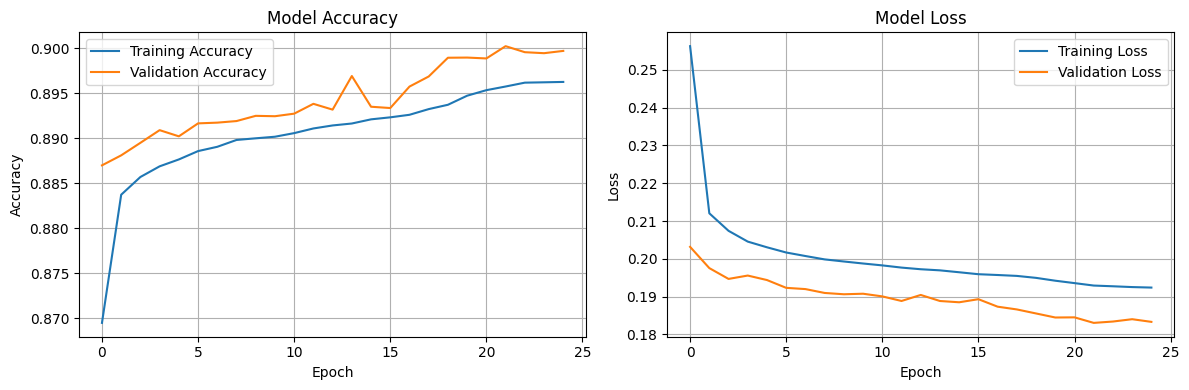

In [6]:
# Hàm này gọi các hàm đã định nghĩa ở trên để thực thi luồng công việc.
# Bước 1, 2: Tiền xử lý chuẩn bị dữ liệu.
X, y, label_counts = preprocess_data(combined_df)
X_train, X_test, y_train, y_test = prepare_data_for_lstm(X, y, label_counts)

# Bước 3: Tạo mô hình
model = create_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

# Bước 4: Thiết lập callbacks
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5, # Theo dõi val_loss (loss trên tập validation), nếu không giảm trong 5 lần (patience=5) thì dừng lại.
    restore_best_weights = True # Khôi phục lại trọng số của mô hình tại epoch có val_loss tốt nhất.
)
model_checkpoint = ModelCheckpoint(
    'model.keras', # theo dõi val_accuracy và chỉ lưu (model.keras) phiên bản có độ chính xác trên tập validation cao nhất.
    monitor = 'val_accuracy',
    save_best_only = True
)

# Bước 5: Huấn luyện mô hình.
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test), # sau mỗi epoch, nó sẽ kiểm tra hiệu năng trên validation_data=(X_test, y_test).
    epochs = 25, # Chạy qua bộ dữ liệu training 25 lần.
    batch_size = 70, # Mỗi lần cập nhật trọng số sẽ dùng 70 mấu.
    callbacks = [early_stopping, model_checkpoint],
    verbose = 1
)

# Bước 6: Đánh giá mô hình.
evaluation = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

# Bước 7: Vẽ biểu đồ kết quả
plt.figure(figsize=(12,4))

# Biểu diễn sự chính xác.
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Biểu diễn sự sai lệch.
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
def Main():
    print("Traning completed!")

Main()

Traning completed!
